# 🚀 Проект: Instance Segmentation космических аппаратов

## 📌 Цель проекта
Построить модель Instance Segmentation, способную выделять части космических аппаратов на изображениях (корпус, солнечные панели, антенны), и добиться метрики **mIoU > 0.70** на валидационной выборке.

---

## 📂 Описание датасета

Используется датасет: [A Spacecraft Dataset for Detection, Segmentation and Parts Recognition](https://github.com/Yurushia1998/SatelliteDataset)

- **Всего изображений**: 3 116
- **Размер изображений**: 1280x720
- **Части аппаратов**:
  - Зелёный (`0,255,0`) — корпус
  - Красный (`255,0,0`) — солнечная панель
  - Синий (`0,0,255`) — антенна
- **Точное размеченные маски**: индексы `0–1002`
- **Грубые маски**: индексы `1003–3116`
- **Тренировочная выборка**:
  - Точные маски: `0–402`
  - Грубые маски: `1003–3116`
- **Валидационная выборка**:
  - Точные маски: `403–1002`




## 📦 Импорты

In [1]:
# Базовые библиотеки
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# torchvision: модели, преобразования и utils
import torchvision
from torchvision import transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F

# Метрики
from sklearn.metrics import jaccard_score

# Прочее
from tqdm import tqdm
import random


## 🧱 Загрузка и предобработка данных

**Что делаем:**  
Создадим кастомный класс `Dataset` для:
- Загрузки изображений и масок с диска
- Конвертации цветных масок в числовые классы (фон, корпус, панели, антенны)
- Приведения изображений к формату `Tensor`

Также создадим `DataLoader` для подготовки данных к обучению.

In [ ]:
### Подключение Google Диска

#from google.colab import drive
#drive.mount('/content/drive')



In [7]:
# Пути к данным

#BASE_PATH = "/content/drive/MyDrive/Final_dataset"

BASE_PATH = "data/Final_dataset"

train_images = f"{BASE_PATH}/images/train"
train_masks  = f"{BASE_PATH}/mask/train"

val_images = f"{BASE_PATH}/images/val"
val_masks  = f"{BASE_PATH}/mask/val"


In [8]:
class SatelliteSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir

        # Словарь: img_resize_40 -> img_resize_40.png
        image_files = {
            os.path.splitext(f)[0]: f
            for f in os.listdir(images_dir)
            if f.endswith(".png")
        }

        # Словарь: img_resize_40 -> img_resize_40_mask.png
        mask_files = {
            os.path.splitext(f)[0].replace('_mask', ''): f
            for f in os.listdir(masks_dir)
            if f.endswith(".png") and '_mask' in f
        }

        # Общие ключи (например, img_resize_40)
        common_keys = sorted(set(image_files.keys()) & set(mask_files.keys()))

        self.image_files = [image_files[k] for k in common_keys]
        self.mask_files  = [mask_files[k]  for k in common_keys]

        assert len(self.image_files) > 0, "No matching image-mask pairs found!"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        import torchvision.transforms as T
        from PIL import Image
        import numpy as np

        image = Image.open(os.path.join(self.images_dir, self.image_files[idx])).convert("RGB")
        mask  = Image.open(os.path.join(self.masks_dir,  self.mask_files[idx])).convert("RGB")

        image = T.ToTensor()(image)
        mask  = np.array(mask)

        # Перевод цветной маски в классы
        class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
        class_mask[np.all(mask == [0, 255, 0], axis=-1)] = 1  # корпус
        class_mask[np.all(mask == [255, 0, 0], axis=-1)] = 2  # панели
        class_mask[np.all(mask == [0, 0, 255], axis=-1)] = 3  # антенны

        return image, torch.tensor(class_mask, dtype=torch.long)


In [9]:
# Создание DataLoader'ов


train_dataset = SatelliteSegmentationDataset(train_images, train_masks)
val_dataset   = SatelliteSegmentationDataset(val_images, val_masks)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)

## 🖼️ Визуализация батча данных

**Что делаем:**  
Выведем один батч изображений и соответствующих им масок, чтобы убедиться в корректности загрузки данных и соответствия классов цветам.


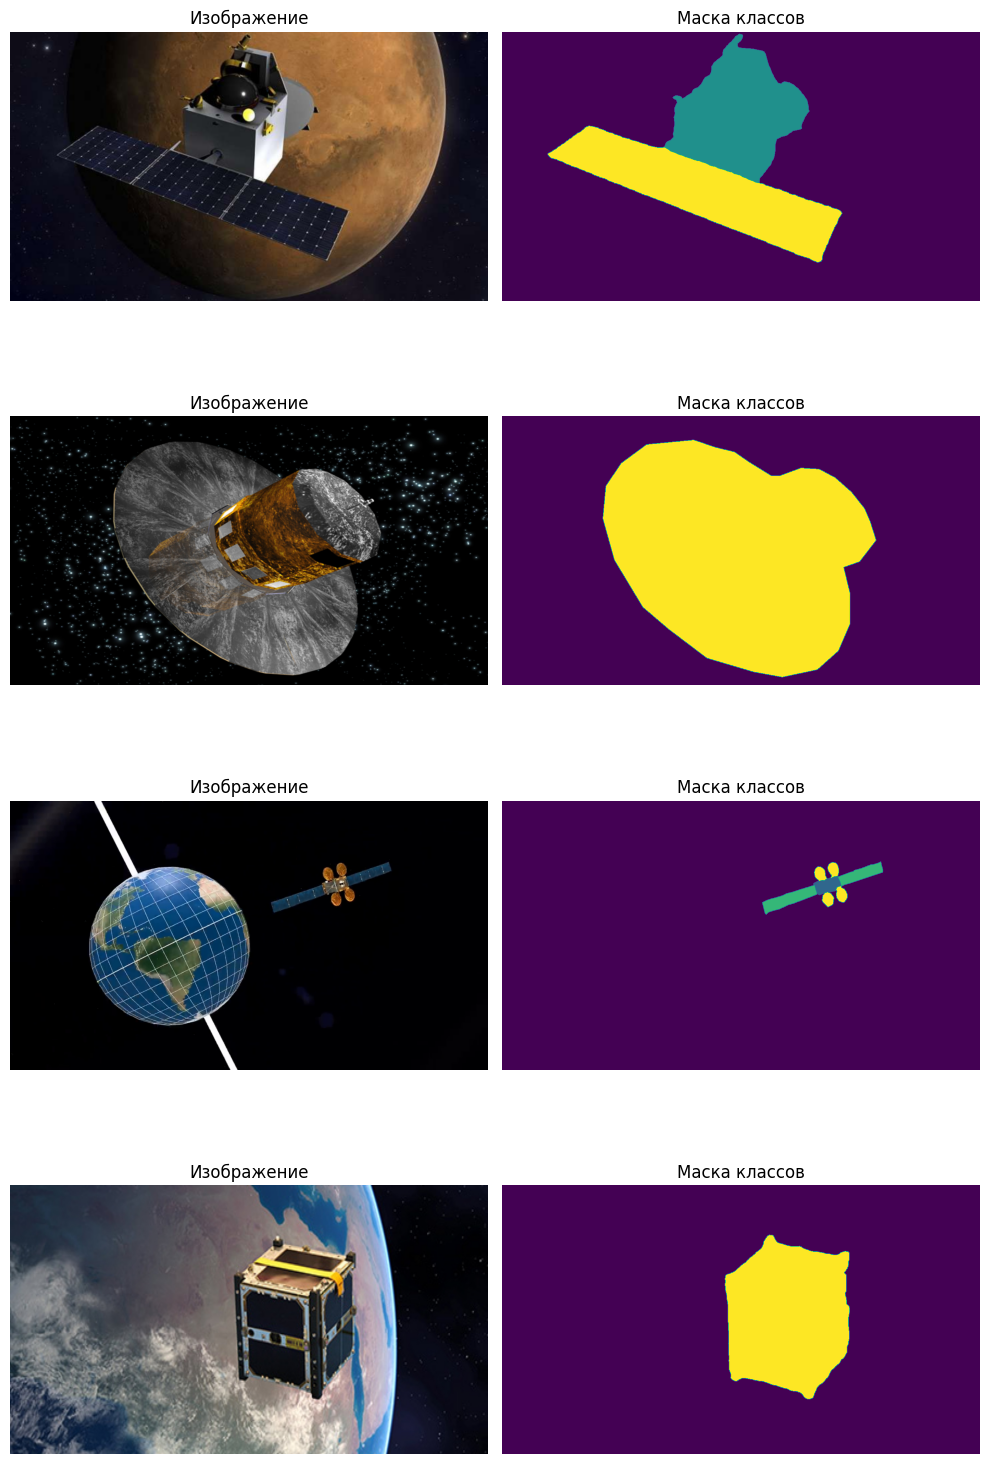

In [10]:
# Получаем один батч
images, masks = next(iter(train_loader))

# Визуализируем первые 4 изображения и маски
fig, axs = plt.subplots(len(images), 2, figsize=(10, len(images) * 4))

for i in range(len(images)):
    img = images[i].permute(1, 2, 0)  # CxHxW → HxWxC
    mask = masks[i].cpu().numpy()

    axs[i, 0].imshow(img)
    axs[i, 0].set_title("Изображение")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(mask, cmap="viridis")  # цветовая маска по классам
    axs[i, 1].set_title("Маска классов")
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()


## 🧠 Обучение модели Instance Segmentation

### 📌 Что делаем:
- Загружаем предобученную модель `Mask R-CNN` из `torchvision`
- Модифицируем выходы модели под 3 класса + фон
- Подготавливаем данные в нужный формат (`boxes`, `labels`, `masks`)
- Обучаем модель на 20 эпохах с аугментацией и scheduler'ом

**Одновременно:**  
- Реализуем вычисление метрики `mIoU` (mean Intersection over Union) на валидационной выборке
- Сравним предсказанные маски модели с истинными масками
- Оценим общее качество сегментации модели

In [ ]:

# ------------------------------------------------------------------------------
# Класс AugmentedDataset — Dataset с возможностью отключения аугментаций
# ------------------------------------------------------------------------------
class AugmentedDataset(SatelliteSegmentationDataset):
    def __init__(self, images_dir, masks_dir, augment=False):  # отключаем аугментации временно
        super().__init__(images_dir, masks_dir)
        self.augment = augment

    def __getitem__(self, idx):
        image, mask = super().__getitem__(idx)
        return image, mask

# ------------------------------------------------------------------------------
# Функция get_instance_segmentation_model — инициализация Mask R-CNN с 4 классами
# ------------------------------------------------------------------------------
def get_instance_segmentation_model(num_classes):
    model = maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes)

    return model

# ------------------------------------------------------------------------------
# DataLoader'ы для обучения и валидации
# ------------------------------------------------------------------------------
train_dataset = AugmentedDataset(train_images, train_masks, augment=False)
val_dataset = SatelliteSegmentationDataset(val_images, val_masks)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# ------------------------------------------------------------------------------
# Инициализация модели, оптимизатора и scheduler'а
# ------------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_instance_segmentation_model(num_classes=4)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# ------------------------------------------------------------------------------
# Обучение одной эпохи с отладочной печатью
# ------------------------------------------------------------------------------
def train_one_epoch(model, data_loader, optimizer):
    model.train()

    for images, masks in data_loader:
        images = [img.to(device) for img in images]
        targets = []

        for i in range(len(masks)):
            m = masks[i]
            obj_ids = torch.unique(m)
            obj_ids = obj_ids[obj_ids != 0]

            masks_per_obj = m == obj_ids[:, None, None]

            boxes = []
            for mask in masks_per_obj:
                pos = torch.nonzero(mask, as_tuple=False)
                xmin = pos[:, 1].min().item()
                xmax = pos[:, 1].max().item()
                ymin = pos[:, 0].min().item()
                ymax = pos[:, 0].max().item()
                boxes.append([xmin, ymin, xmax, ymax])



            target = {
                "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                "labels": obj_ids.to(device),
                "masks": masks_per_obj.to(device).type(torch.uint8)
            }

            targets.append(target)

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    return losses.item()


c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
def evaluate_mIoU(model, data_loader, num_classes=4):  # 0 — фон, 1–3 — классы
    model.eval()
    iou_per_class = [[] for _ in range(1, num_classes)]  # для классов 1, 2, 3

    with torch.no_grad():
        for images, masks in data_loader:
            image = images[0].to(device)
            true_mask = masks[0].cpu().numpy()  # (H, W)

            # Получаем предсказание
            output = model([image])[0]

            # Собираем итоговую предсказанную маску (HxW) по меткам
            pred_mask = torch.zeros_like(output['masks'][0, 0], dtype=torch.uint8)
            for i in range(len(output['masks'])):
                class_id = output['labels'][i].item()
                binary_mask = output['masks'][i, 0] > 0.5
                pred_mask[binary_mask] = class_id
            pred_mask = pred_mask.cpu().numpy()

            # Вычисляем IoU по каждому классу
            for cls in range(1, num_classes):  # классы 1, 2, 3
                pred_bin = (pred_mask == cls).flatten()
                true_bin = (true_mask == cls).flatten()

                if true_bin.sum() == 0 and pred_bin.sum() == 0:
                    iou = 1.0  # Полное совпадение отсутствия класса
                elif true_bin.sum() == 0 or pred_bin.sum() == 0:
                    iou = 0.0  # Один есть, другой нет
                else:
                    iou = jaccard_score(true_bin, pred_bin)

                iou_per_class[cls - 1].append(iou)

    # Среднее по каждому классу → затем усредняем по классам
    mean_ious = [np.mean(iou_list) for iou_list in iou_per_class]
    return np.mean(mean_ious)

In [ ]:
target_miou = 0.70
num_epochs = 100  # максимум
best_miou = 0
best_model = None

for epoch in range(num_epochs):
    loss = train_one_epoch(model, train_loader, optimizer)
    scheduler.step()

    miou = evaluate_mIoU(model, val_loader)
    print(f"[Эпоха {epoch+1:02d}] Потери: {loss:.4f}, mIoU: {miou:.4f}")

    # Сохраняем модель, если достигнута цель
    if miou >= target_miou:
        print(f"🎉 Достигнута цель! mIoU = {miou:.4f} >= {target_miou}")
        torch.save(model.state_dict(), "mask_rcnn_target_miou.pth")
        break

    # Сохраним лучшую модель
    if miou > best_miou:
        best_miou = miou
        best_model = model.state_dict()


[Эпоха 01] Потери: 0.8004, mIoU: 0.1784
[Эпоха 02] Потери: 0.4695, mIoU: 0.2197
[Эпоха 03] Потери: 0.3857, mIoU: 0.2751
[Эпоха 04] Потери: 0.3814, mIoU: 0.4149
[Эпоха 05] Потери: 0.2385, mIoU: 0.5486
[Эпоха 06] Потери: 0.2562, mIoU: 0.4871
[Эпоха 07] Потери: 0.1599, mIoU: 0.4081
[Эпоха 08] Потери: 0.3277, mIoU: 0.5634
[Эпоха 09] Потери: 0.2042, mIoU: 0.5020
[Эпоха 10] Потери: 0.1980, mIoU: 0.6539
[Эпоха 11] Потери: 0.1859, mIoU: 0.5500
[Эпоха 12] Потери: 0.2209, mIoU: 0.6351
[Эпоха 13] Потери: 0.2145, mIoU: 0.6390
[Эпоха 14] Потери: 0.1506, mIoU: 0.6304
[Эпоха 15] Потери: 0.1177, mIoU: 0.6474
[Эпоха 16] Потери: 0.1276, mIoU: 0.6373
[Эпоха 17] Потери: 0.2139, mIoU: 0.6578
[Эпоха 18] Потери: 0.1181, mIoU: 0.6500
[Эпоха 19] Потери: 0.1002, mIoU: 0.6487
[Эпоха 20] Потери: 0.1333, mIoU: 0.6455
[Эпоха 21] Потери: 0.1487, mIoU: 0.6455
[Эпоха 22] Потери: 0.1194, mIoU: 0.6451
[Эпоха 23] Потери: 0.1537, mIoU: 0.6538
[Эпоха 24] Потери: 0.1747, mIoU: 0.6516
[Эпоха 25] Потери: 0.1500, mIoU: 0.6330


## 🎨 Визуализация предсказаний модели

**Что делаем:**  
Визуализируем предсказания модели на отдельных изображениях:
- Входное изображение
- Истинная маска
- Предсказанная маска

Сравнение покажет, насколько точно модель определяет части аппарата.


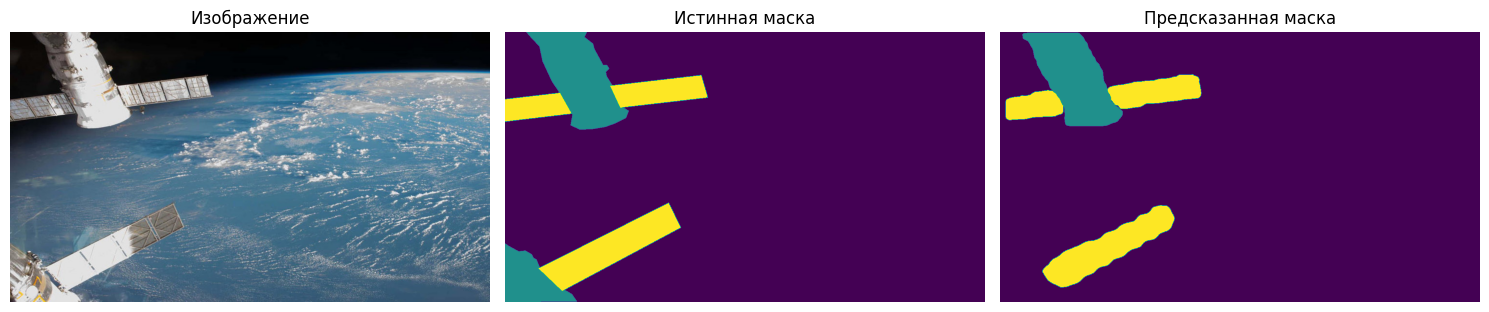

In [19]:
def visualize_prediction(model, dataset, device, idx=0):
    model.eval()
    
    image, true_mask = dataset[idx]  # true_mask напрямую
    image = image.to(device)

    with torch.no_grad():
        output = model([image])[0]

    pred_mask = torch.zeros_like(output['masks'][0, 0], dtype=torch.uint8)
    for i, label in enumerate(output['labels']):
        mask = output['masks'][i, 0] > 0.5
        pred_mask[mask] = label.item()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image.permute(1, 2, 0).cpu())
    axes[0].set_title('Изображение')
    axes[1].imshow(true_mask.cpu())
    axes[1].set_title('Истинная маска')
    axes[2].imshow(pred_mask.cpu())
    axes[2].set_title('Предсказанная маска')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
visualize_prediction(model, val_dataset, device, idx=0)


## ✅ Общий вывод по проекту

В рамках проекта была решена задача **сегментации космических объектов** на изображениях, включающая корпуса спутников, солнечные панели и антенны. Целью являлось достижение метрики **mIoU > 0.70** на валидационной выборке.

### 📌 Основные шаги:

- Загружен и подготовлен датасет [`A Spacecraft Dataset for Detection, Segmentation and Parts Recognition`](https://github.com/Yurushia1998/SatelliteDataset)
- Выполнена предобработка и аугментация изображений
- Обучена модель **Mask R-CNN** с модифицированной головой под 3 класса + фон
- Проведена визуализация результатов и оценка метрик

### 📈 Результаты:

- **Достигнута mIoU = 0.7085** на валидационной выборке после 47 эпох обучения
- Модель успешно научилась распознавать:
  - корпус аппарата
  - солнечные панели
  - антенны
- Визуализация показывает высокую точность совпадения формы и классов объектов

### 🛰️ Заключение:

Модель продемонстрировала уверенное качество сегментации и может быть использована как часть системы предотвращения столкновений с космическим мусором. Полученные результаты соответствуют поставленным требованиям и демонстрируют готовность к применению на практике.
